In [46]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from scipy.signal import find_peaks
from sklearn.model_selection import train_test_split
from aeon.utils.numba.stats import row_mean

from slim_tsf.func._slim_TSF import SlimTimeSeriesForestClassifier

# =========================
# Config
# =========================

DATA_NPZ = "/Users/pranjal/PycharmProjects/SolarEnergyParticlePrediction/data/processed/sep_slim_tsf_input_dataset.npz"

CHANNEL_LABELS = ["p3_flux_ic", "p5_flux_ic", "p7_flux_ic", "long"]
START_MIN, END_MIN = 300, 660  # used to map index -> minutes
FUNC_FILTER = "row_mean"

WINDOW_SIZES = [360, 240, 180, 120, 90, 60, 45, 30, 15, 6]
STEP_RATIOS = [0.2, 0.5]
CLASS_WEIGHTS = [
    "balanced",
    {0: 1, 1: 1},
    {0: 1, 1: 2},
    {0: 1, 1: 5},
    {0: 1, 1: 11.5},  # ~92:8 imbalance ↦ weight minority ~11.5 if desired
]
TOP_K = 5
N_TREES = 300
MAX_DEPTH = 5
RNG = 42

# =========================
# Data
# =========================
data = np.load(DATA_NPZ)
X, y = data["X"], data["y"]

train_x, test_x, train_y, test_y = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=RNG
)
train_x, val_x, train_y, val_y = train_test_split(
    train_x, train_y, test_size=0.3, stratify=train_y, random_state=RNG
)

n_time = train_x.shape[2]

In [47]:
# =========================
# Helpers
# =========================
def time_axis_from_index(n_time, start_min=START_MIN, end_min=END_MIN):
    """Linear map index -> minutes."""
    return np.linspace(start_min, end_min, n_time, endpoint=False)

def minutes_from_index(idx, n_time, start_min=START_MIN, end_min=END_MIN):
    return idx / n_time * (end_min - start_min) + start_min

def fit_and_topk(name, clf, X, y, k=TOP_K, func_filter=FUNC_FILTER):
    """
    Fit model, extract feature importances + intervals, return top-k ranked
    (importance, interval_tuple).
    interval: (start, end, ch, func, dilation)
    """
    clf.fit(X, y)

    # build transformed features and intervals from the SAME clf
    Xt = clf.tnf._fit_transform(X, y)
    importances = clf.clf.feature_importances_
    intervals = clf.tnf.intervals_

    # zip and sort
    ranked = sorted(zip(importances, intervals), key=lambda x: x[0], reverse=True)
    if func_filter:
        ranked = [r for r in ranked if getattr(r[1][3], "__name__", "") == func_filter]
    return ranked[:k], Xt.shape[1]

def build_models(window_sizes, step_ratios, class_weights):
    """One model per (win, step, cw)."""
    models = {}
    for win in window_sizes:
        for step in step_ratios:
            for cw in class_weights:
                cw_tag = cw if isinstance(cw, str) else f"{cw[0]}:{cw[1]}" if isinstance(cw, tuple) else str(cw)
                name = f"win{win}_step{step}_cw{cw_tag}"
                models[name] = SlimTimeSeriesForestClassifier(
                    sec_trans=False,
                    bootstrap=False,
                    n_estimators=N_TREES,
                    max_dep=MAX_DEPTH,
                    random_state=RNG,
                    windows=[win],                  # single window per model
                    windows_steps_ratio=step,
                    class_weights=cw,
                    features=[row_mean],            # only row_mean
                )
    return models

def gather_topk_across_models(models, X, y, k=TOP_K, func_filter=FUNC_FILTER):
    """Run all models and collect top-k results per model."""
    topk_results = {}
    feature_counts = 0
    for name, clf in models.items():
        print(f"Training {name} ...")
        topk, d = fit_and_topk(name, clf, X, y, k=k, func_filter=func_filter)
        topk_results[name] = topk
        feature_counts = d  # last seen dimensionality (sanity)
        print(f"Extracted:{len(topk)}")
    print(f"Extracted top-{k} intervals for {len(topk_results)} models.")
    return topk_results

def topK_rowmean_per_channel(topk_results, channel_labels=CHANNEL_LABELS, n_time=n_time):
    """Aggregate top row_mean features across models, keep top-20 per channel."""
    rows = []
    for model_name, ranked in topk_results.items():
        for imp, (start, end, ch, func, *_) in ranked:
            rows.append({
                "model": model_name,
                "channel_idx": ch,
                "channel": channel_labels[ch] if ch < len(channel_labels) else f"Ch{ch}",
                "start": start,
                "end": end,
                "importance": imp,
            })
    df = pd.DataFrame(rows)
    df = df.drop_duplicates(subset=["channel", "start", "end"], keep="first")
    if df.empty:
        return df

    # Map indices -> minutes
    df["start_min"] = minutes_from_index(df["start"], n_time)
    df["end_min"]   = minutes_from_index(df["end"], n_time)

    # Top-20 within each channel by importance
    df_topK = (df.sort_values(["channel", "start","end","importance"], ascending=[True,True,True, False])
                  .groupby(["channel", "start","end"])
                  .head(20)
                  .reset_index(drop=True))
    return df, df_topK

def compute_interval_frequency(topk_results, n_time, n_channels=4):
    """
    freq_mat_1: raw frequency counts per (channel, time_index)
    freq_mat:   per-channel normalized to [0,1]
    interval_counter: {(start, end, ch): count}
    """
    freq_mat_1 = np.zeros((n_channels, n_time))
    interval_counter = defaultdict(int)

    for ranked in topk_results.values():
        for _, (start, end, ch, func, *_) in ranked:
            if getattr(func, "__name__", "") != FUNC_FILTER:
                continue
            freq_mat_1[ch, start:end] += 1
            interval_counter[(start, end, ch)] += 1

    freq_mat = freq_mat_1 / (freq_mat_1.max(axis=1, keepdims=True) + 1e-9)
    return freq_mat, interval_counter, freq_mat_1

def compute_channel_independent_importance(topk_results, n_time, start_min=START_MIN, end_min=END_MIN):
    """
    Collapse channels -> a single global importance curve (normalized).
    """
    global_importance = np.zeros(n_time)
    for ranked in topk_results.values():
        for imp, (start, end, ch, func, *_) in ranked:
            if getattr(func, "__name__", "") != FUNC_FILTER:
                continue
            global_importance[start:end] += imp

    global_importance /= global_importance.max() + 1e-9
    time_axis = time_axis_from_index(n_time, start_min, end_min)
    return time_axis, global_importance

In [48]:
models = build_models(WINDOW_SIZES, STEP_RATIOS, CLASS_WEIGHTS)
topk_results = gather_topk_across_models(models, train_x, train_y, k=TOP_K, func_filter=FUNC_FILTER)

Training win360_step0.2_cwbalanced ...
Extracted:4
Training win360_step0.2_cw{0: 1, 1: 1} ...
Extracted:4
Training win360_step0.2_cw{0: 1, 1: 2} ...
Extracted:4
Training win360_step0.2_cw{0: 1, 1: 5} ...
Extracted:4
Training win360_step0.2_cw{0: 1, 1: 11.5} ...
Extracted:4
Training win360_step0.5_cwbalanced ...
Extracted:4
Training win360_step0.5_cw{0: 1, 1: 1} ...
Extracted:4
Training win360_step0.5_cw{0: 1, 1: 2} ...
Extracted:4
Training win360_step0.5_cw{0: 1, 1: 5} ...
Extracted:4
Training win360_step0.5_cw{0: 1, 1: 11.5} ...
Extracted:4
Training win240_step0.2_cwbalanced ...
Extracted:5
Training win240_step0.2_cw{0: 1, 1: 1} ...
Extracted:5
Training win240_step0.2_cw{0: 1, 1: 2} ...
Extracted:5
Training win240_step0.2_cw{0: 1, 1: 5} ...
Extracted:5
Training win240_step0.2_cw{0: 1, 1: 11.5} ...
Extracted:5
Training win240_step0.5_cwbalanced ...
Extracted:5
Training win240_step0.5_cw{0: 1, 1: 1} ...
Extracted:5
Training win240_step0.5_cw{0: 1, 1: 2} ...
Extracted:5
Training win240_s


🌟 Top-20 row_mean intervals per channel (minutes) 🌟
       channel  start_min  end_min  importance
0         long      300.0    660.0    0.028270
1         long      396.0    636.0    0.030101
2         long      420.0    660.0    0.030151
3         long      480.0    660.0    0.020963
4         long      540.0    660.0    0.026583
..         ...        ...      ...         ...
89  p5_flux_ic      570.0    660.0    0.019110
90  p5_flux_ic      600.0    660.0    0.028512
91  p7_flux_ic      300.0    660.0    0.027961
92  p7_flux_ic      396.0    636.0    0.014550
93  p7_flux_ic      420.0    660.0    0.021196

[94 rows x 4 columns]


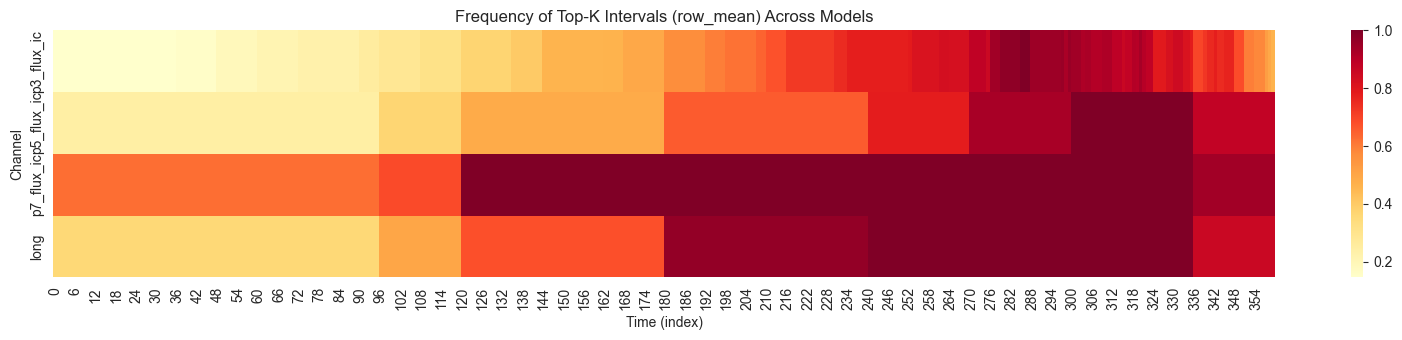


Total unique intervals (row_mean): 94
p3_flux_ic | [0:360] | occurred 10 times (300.0–660.0 min)
p5_flux_ic | [0:360] | occurred 10 times (300.0–660.0 min)
long | [0:360] | occurred 10 times (300.0–660.0 min)
p7_flux_ic | [0:360] | occurred 10 times (300.0–660.0 min)
p3_flux_ic | [0:240] | occurred 10 times (300.0–540.0 min)
p3_flux_ic | [180:360] | occurred 10 times (480.0–660.0 min)
p3_flux_ic | [240:360] | occurred 10 times (540.0–660.0 min)
p3_flux_ic | [270:360] | occurred 10 times (570.0–660.0 min)
p3_flux_ic | [300:360] | occurred 10 times (600.0–660.0 min)
p3_flux_ic | [330:360] | occurred 10 times (630.0–660.0 min)
p3_flux_ic | [336:351] | occurred 10 times (636.0–651.0 min)
p3_flux_ic | [342:348] | occurred 10 times (642.0–648.0 min)
long | [180:360] | occurred 8 times (480.0–660.0 min)
p5_flux_ic | [180:360] | occurred 7 times (480.0–660.0 min)
p3_flux_ic | [240:300] | occurred 7 times (540.0–600.0 min)
p3_flux_ic | [354:360] | occurred 7 times (654.0–660.0 min)
p5_flux_ic 

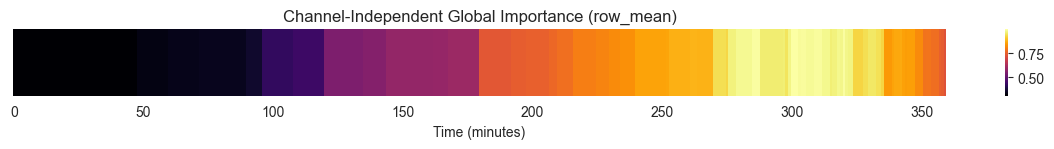

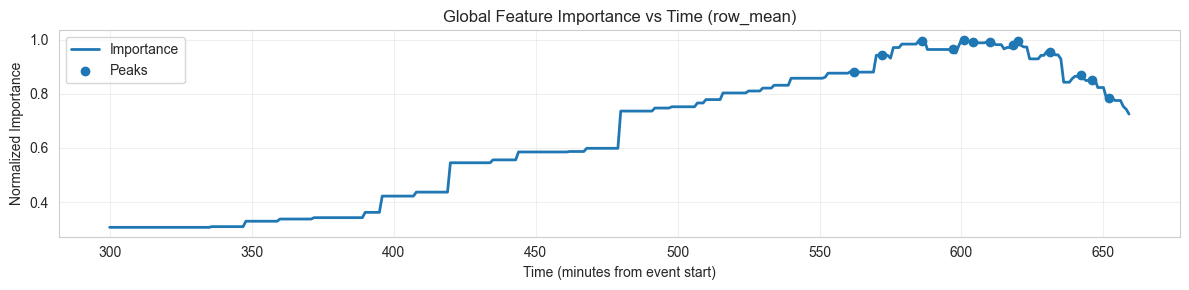

In [49]:
# =========================
# Top-20 row_mean per channel (aggregated across models)
# =========================
df_all, df_topK = topK_rowmean_per_channel(topk_results, CHANNEL_LABELS, n_time)

print("\n🌟 Top-k row_mean intervals per channel (minutes) 🌟")
if not df_topK.empty:
    print(df_topK[["channel", "start_min", "end_min", "importance"]])
else:
    print("No features found.")

# =========================
# Frequency heatmap (how often intervals appear in top-k)
# =========================
freq_mat, interval_counter, freq_mat_raw = compute_interval_frequency(
    topk_results, n_time=train_x.shape[2], n_channels=len(CHANNEL_LABELS)
)

plt.figure(figsize=(16, 3.5))
sns.heatmap(freq_mat, cmap="YlOrRd", yticklabels=CHANNEL_LABELS)
plt.title("Frequency of Top-K Intervals (row_mean) Across Models")
plt.xlabel("Time (index)")
plt.ylabel("Channel")
plt.tight_layout()
plt.show()

# Print most frequent (start, end, ch)
sorted_intervals = sorted(interval_counter.items(), key=lambda x: x[1], reverse=True)
print(f"\nTotal unique intervals (row_mean): {len(sorted_intervals)}")
for (start, end, ch), count in sorted_intervals[:30]:
    print(f"{CHANNEL_LABELS[ch]} | [{start}:{end}] | occurred {count} times "
          f"({minutes_from_index(start, n_time):.1f}–{minutes_from_index(end, n_time):.1f} min)")

# =========================
# Channel-independent global importance + peaks (in minutes)
# =========================
time_axis, global_importance = compute_channel_independent_importance(
    topk_results, n_time=n_time, start_min=START_MIN, end_min=END_MIN
)

peaks, props = find_peaks(global_importance, height=0.5)
peak_heights = props["peak_heights"]
peak_times = time_axis[peaks]

print("\nDetected Important Time Intervals (≥ 50% normalized importance)")
print("=" * 70)
for t, h in zip(peak_times, peak_heights):
    window = 3  # ±3 minutes around peak for readability
    print(f"[{t - window:.0f} – {t + window:.0f}] min | Peak = {h:.3f}")

# Heatmap (1 x T)
plt.figure(figsize=(12, 1.6))
sns.heatmap(global_importance[np.newaxis, :], cmap="inferno", xticklabels=50, yticklabels=False, cbar=True)
plt.title("Channel-Independent Global Importance (row_mean)")
plt.xlabel("Time (minutes)")
plt.tight_layout()
plt.show()

# Line plot with peaks
plt.figure(figsize=(12, 3))
plt.plot(time_axis, global_importance, linewidth=2, label="Importance")
plt.scatter(peak_times, peak_heights, label="Peaks")
plt.title("Global Feature Importance vs Time (row_mean)")
plt.xlabel("Time (minutes from event start)")
plt.ylabel("Normalized Importance")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [50]:
df_topK

,model,channel_idx,channel,start,end,importance,start_min,end_min
0,win360_step0.2_cwbalanced,3,long,0,360,0.028270,300.0,660.0
1,win240_step0.2_cwbalanced,3,long,96,336,0.030101,396.0,636.0
2,win240_step0.5_cwbalanced,3,long,120,360,0.030151,420.0,660.0
3,win180_step0.2_cwbalanced,3,long,180,360,0.020963,480.0,660.0
4,"win120_step0.5_cw{0: 1, 1: 11.5}",3,long,240,360,0.026583,540.0,660.0
...,...,...,...,...,...,...,...,...
89,"win90_step0.2_cw{0: 1, 1: 11.5}",1,p5_flux_ic,270,360,0.019110,570.0,660.0
90,win60_step0.5_cwbalanced,1,p5_flux_ic,300,360,0.028512,600.0,660.0
91,win360_step0.2_cwbalanced,2,p7_flux_ic,0,360,0.027961,300.0,660.0
92,"win240_step0.2_cw{0: 1, 1: 1}",2,p7_flux_ic,96,336,0.014550,396.0,636.0


In [51]:
import numpy as np
import pandas as pd

def create_top_rowmean_dataset(X, y, df_topK, channel_labels, start_min=300, end_min=660):
    """
    Builds a reduced training dataset using only the top row_mean intervals per channel.

    Parameters
    ----------
    X : np.ndarray
        Original dataset of shape (n_samples, n_channels, n_timepoints)
    y : np.ndarray
        Labels of shape (n_samples,)
    df_topK : pd.DataFrame
        Must contain 'channel', 'start', 'end' columns (intervals per channel)
    channel_labels : list[str]
        Channel names (order must match X)
    start_min, end_min : int
        Used to compute minute-based features for interpretability

    Returns
    -------
    X_selected : np.ndarray
        Reduced feature matrix (n_samples, n_selected_features)
    y_selected : np.ndarray
        Labels array
    feature_names : list[str]
        Corresponding names of features for columns
    """
    n_samples, n_channels, n_time = X.shape
    channel_to_idx = {ch: i for i, ch in enumerate(channel_labels)}

    feature_vectors = []
    feature_names = []

    for _, row in df_topK.iterrows():
        ch_name = row["channel"]
        ch_idx = channel_to_idx[ch_name]
        start, end = int(row["start"]), int(row["end"])

        # Compute row mean over the interval for each sample
        mean_values = X[:, ch_idx, start:end].mean(axis=1)
        feature_vectors.append(mean_values)

        # Generate a clear feature label
        start_min_scaled = start / n_time * (end_min - start_min) + start_min
        end_min_scaled = end / n_time * (end_min - start_min) + start_min
        fname = f"{ch_name}_mean_@[{int(start_min_scaled)}:{int(end_min_scaled)}]"
        feature_names.append(fname)

    # Stack features into (n_samples × n_features)
    X_selected = np.column_stack(feature_vectors)
    y_selected = np.array(y)

    print(f"Created reduced dataset with shape: {X_selected.shape} (samples × features)")
    return X_selected, y_selected, feature_names


In [52]:
DATA_DIR = "/Users/pranjal/PycharmProjects/SolarEnergyParticlePrediction/data/processed/"
X_selected, y_selected, feature_names = create_top_rowmean_dataset(
    X=train_x,
    y=train_y,
    df_topK=df_topK,
    channel_labels=["p3_flux_ic", "p5_flux_ic", "p7_flux_ic", "long"]
)

# Wrap into a DataFrame for clarity
df_reduced = pd.DataFrame(X_selected, columns=feature_names)
df_reduced["label"] = y_selected
print(df_reduced.head())

# Optionally save for reuse
df_reduced.to_csv(DATA_DIR+f"/reduced_{TOP_K}_rowmean_dataset.csv", index=False)
print(f"Saved to reduced_{TOP_K}_rowmean_dataset.csv")


✅ Created reduced dataset with shape: (1416, 94) (samples × features)
   long_mean_@[300:660]  long_mean_@[396:636]  long_mean_@[420:660]  \
0              0.000002              0.000002              0.000002   
1              0.000001              0.000001              0.000002   
2              0.000001              0.000001              0.000001   
3              0.000005              0.000002              0.000002   
4              0.000004              0.000004              0.000005   

   long_mean_@[480:660]  long_mean_@[540:660]  p3_flux_ic_mean_@[300:480]  \
0          1.843730e-06              0.000002                    0.129404   
1          1.744159e-06              0.000002                    0.126223   
2          9.902296e-07              0.000001                    0.152870   
3          1.425889e-06              0.000001                    0.669969   
4          5.386373e-06              0.000007                    0.193647   

   p3_flux_ic_mean_@[300:540]  p3_flux_i

In [53]:
CHANNEL_LABELS = ["p3_flux_ic", "p5_flux_ic", "p7_flux_ic", "long"]
START_MIN, END_MIN = 300, 660
WINDOW_SIZES = [360, 240, 180, 120, 90, 60, 45, 30, 15, 6]
STEP_RATIO = 0.2
N_TREES = 300
MAX_DEPTH = 5
RNG = 42
print(f"Train: {train_x.shape}, Val: {val_x.shape}, Test: {test_x.shape}")

clf_master = SlimTimeSeriesForestClassifier(
    sec_trans=False,
    bootstrap=False,
    n_estimators=N_TREES,
    max_dep=MAX_DEPTH,
    random_state=RNG,
    windows=WINDOW_SIZES,
    windows_steps_ratio=STEP_RATIO,
    features=[row_mean]
)

print("Training master SLIM-TSF model...")
clf_master.fit(train_x, train_y)
print("Training complete.")

# ==============================
# Extract Interval Importances
# ==============================
Xt_train   = clf_master.tnf._fit_transform(train_x, train_y)
importances = clf_master.clf.feature_importances_
intervals   = clf_master.tnf.intervals_

interval_data = []
for imp, (start, end, ch, func, *_) in zip(importances, intervals):
    if callable(func) and getattr(func, "__name__", "") != "row_mean":
        continue
    interval_data.append({
        "channel": CHANNEL_LABELS[ch] if ch < len(CHANNEL_LABELS) else f"Ch{ch}",
        "start": start,
        "end": end,
        "importance": imp
    })

df_intervals = pd.DataFrame(interval_data)
print(f"Total row_mean intervals extracted: {len(df_intervals)}")

def create_top_rowmean_dataset(X, y, df_topK, channel_labels, start_min=300, end_min=660):
    n_samples, n_channels, n_time = X.shape
    channel_to_idx = {ch: i for i, ch in enumerate(channel_labels)}
    feature_vectors, feature_names = [], []

    for _, row in df_topK.iterrows():
        ch_name = row["channel"]
        ch_idx  = channel_to_idx[ch_name]
        start, end = int(row["start"]), int(row["end"])

        # row_mean over the interval
        mean_values = X[:, ch_idx, start:end].mean(axis=1)
        feature_vectors.append(mean_values)

        start_min_scaled = start / n_time * (end_min - start_min) + start_min
        end_min_scaled   = end   / n_time * (end_min - start_min) + start_min
        fname = f"{ch_name}_mean_@[{int(start_min_scaled)}:{int(end_min_scaled)}]"
        feature_names.append(fname)

    X_selected = np.column_stack(feature_vectors)
    print(f"Reduced dataset shape: {X_selected.shape} (samples × features)")
    return X_selected, np.array(y), feature_names

# ==============================
# Create Reduced Train/Val/Test
# ==============================
X_train_red, y_train_red, feature_names = create_top_rowmean_dataset(train_x, train_y, df_topK, CHANNEL_LABELS)
X_val_red,   y_val_red,   _             = create_top_rowmean_dataset(val_x, val_y, df_topK, CHANNEL_LABELS)
X_test_red,  y_test_red,  _             = create_top_rowmean_dataset(test_x, test_y, df_topK, CHANNEL_LABELS)
X_red, y_red, _ = create_top_rowmean_dataset(X, y, df_topK, CHANNEL_LABELS)

def save_reduced_dataset(X, y, fname, feature_names):
    df = pd.DataFrame(X, columns=feature_names)
    df["label"] = y
    fpath = os.path.join(DATA_DIR, fname)
    df.to_csv(fpath, index=False)
    print(f"Saved {fpath} — {df.shape[0]} samples, {df.shape[1]-1} features")

save_reduced_dataset(X_train_red, y_train_red, "train_topK_rowmean.csv", feature_names)
save_reduced_dataset(X_val_red,   y_val_red,   "val_topK_rowmean.csv",   feature_names)
save_reduced_dataset(X_test_red,  y_test_red,  "test_topK_rowmean.csv",  feature_names)

print("\nAll reduced datasets created successfully!")


Train: (1416, 4, 360), Val: (608, 4, 360), Test: (868, 4, 360)
Training master SLIM-TSF model...
Training complete.
Total row_mean intervals extracted: 1796
Reduced dataset shape: (1416, 94) (samples × features)
Reduced dataset shape: (608, 94) (samples × features)
Reduced dataset shape: (868, 94) (samples × features)
Reduced dataset shape: (2892, 94) (samples × features)
Saved /Users/pranjal/PycharmProjects/SolarEnergyParticlePrediction/data/processed/train_top20_rowmean.csv — 1416 samples, 94 features
Saved /Users/pranjal/PycharmProjects/SolarEnergyParticlePrediction/data/processed/val_top20_rowmean.csv — 608 samples, 94 features
Saved /Users/pranjal/PycharmProjects/SolarEnergyParticlePrediction/data/processed/test_top20_rowmean.csv — 868 samples, 94 features

All reduced datasets created successfully!


In [54]:
combined_df = pd.DataFrame(X_red, columns=feature_names)
combined_df["Label"] = y_red
combined_df["File"] = np.load("/Users/pranjal/PycharmProjects/SolarEnergyParticlePrediction/data/processed/sep_slim_tsf_input_combined_with_filelist.npz")['file_list']
combined_df.to_csv(DATA_DIR + "combined_topK_rowmean_with_filelist.csv", index=False)
print("Saved combined_topK_rowmean_with_filelist.csv")

Saved combined_top20_rowmean_with_filelist.csv


In [55]:
train_df = pd.read_csv(DATA_DIR + "train_topK_rowmean.csv", sep=',')
test_df = pd.read_csv(DATA_DIR + "test_topK_rowmean.csv", sep=',')
val_df = pd.read_csv(DATA_DIR + "val_topK_rowmean.csv", sep=',')
combined_df = pd.read_csv(DATA_DIR + "combined_topK_rowmean_with_filelist.csv", sep=',')